In [1]:
import numpy as py
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM, Dense, LayerNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Masking

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.models import load_model 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import random
import os
import pickle
import re
import matplotlib.pyplot as plt

In [2]:
#Load Data
df = pd.read_csv('/kaggle/input/layoutlm/medquad.csv')

# Sampel Data
print("Data Sample")
print(df.head())

#Null value
print("Null Value Data")
print(df.isnull().sum())

duplicates = df.duplicated(['question'], keep=False).sum()
print(f"Total duplicates in 'question' column: {duplicates}")

# Check for duplicate rows

duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows
df = df.drop_duplicates()

# Reset the index after removing duplicates
df.reset_index(drop=True, inplace=True)

#Delete Unused column
df = df.drop(columns=['source', 'focus_area'])

#Table Info
print("Table Info")
print(df.info())

# Apply the function
df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

#Drop rows with null values
df.dropna(inplace=True)

#Checking again of null values
print("Null Value Data")
print(df.isnull().sum())

#Checking again of the data info
print(df.info())

#Check for Unique Data
print(f"Unique questions: {df['question'].nunique()}")
print(f"Unique answers: {df['answer'].nunique()}")

df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
print(df.head())

Data Sample
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Null Value Data
question       0
answer         5
source         0
focus_area    14
dtype: int64
Total duplicates in 'question' column: 2319
Number of duplicate rows: 48
Table Info
<class 

Epoch 1/3
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.8033 - loss: 7.2930
Epoch 1: val_loss improved from inf to 2.56566, saving model to seq2seq_checkpoint.weights.h5
362/362 ━━━━━━━━━━━━━━━━━━━━ 280s 753ms/step - accuracy: 0.8037 - loss: 7.2889 - val_accuracy: 0.9540 - val_loss: 2.5657 - learning_rate: 9.9852e-05
Epoch 2/3
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9525 - loss: 1.7594
Epoch 2: val_loss improved from 2.56566 to 0.60371, saving model to seq2seq_checkpoint.weights.h5
362/362 ━━━━━━━━━━━━━━━━━━━━ 271s 747ms/step - accuracy: 0.9525 - loss: 1.7579 - val_accuracy: 0.9540 - val_loss: 0.6037 - learning_rate: 9.9705e-05
Epoch 3/3
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.9520 - loss: 0.5507
Epoch 3: val_loss improved from 0.60371 to 0.39751, saving model to seq2seq_checkpoint.weights.h5
362/362 ━━━━━━━━━━━━━━━━━━━━ 272s 752ms/step - accuracy: 0.9520 - loss: 0.5505 - val_accuracy: 0.9540 - val_loss: 0.3975 - learning_rate: 9.9558e-05
En

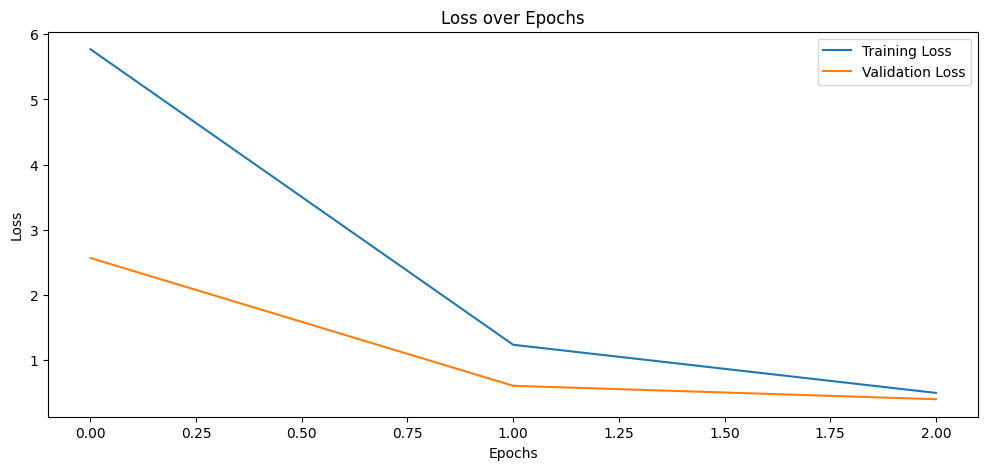

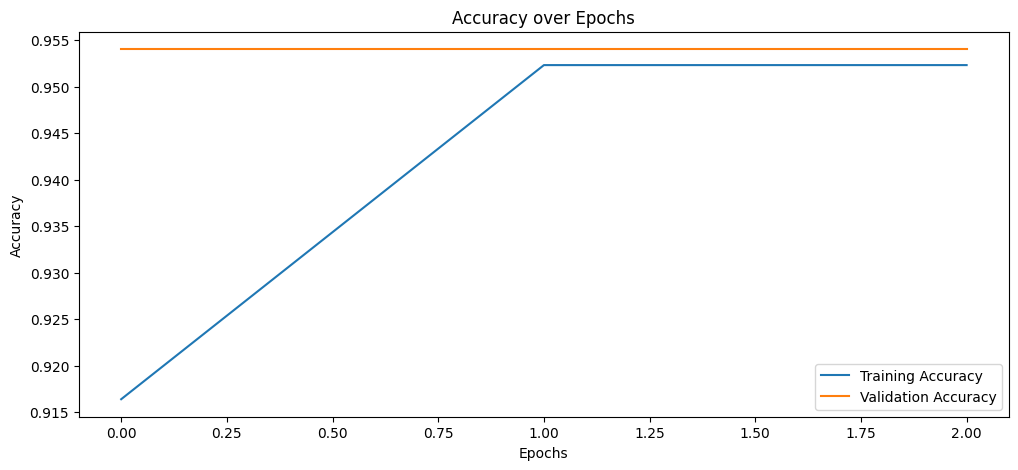

Training set size: 11570
Validation set size: 2893
Max question length: 27
Max answer length: 517


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 516)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 27, 32)    │    160,064 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 516, 32)   │    160,064 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 27, 32)    │         64 │ embedding[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 516, 32)   │         64 │ embedding_1[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 64),      │     24,832 │ layer_normalizat… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 516, 64), │     24,832 │ layer_normalizat… │
│                     │ (None, 64),       │            │ lstm[0][1],       │
│                     │ (None, 64)]       │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 516, 5002) │    325,130 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,085,151 (7.95 MB)

 Trainable params: 695,050 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,390,101 (5.30 MB)

In [ ]:
# Data Preprocessing
def preprocess_text(text):
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)  
    return text

df['question'] = df['question'].apply(preprocess_text)
df['answer'] = df['answer'].apply(preprocess_text)

# Truncate each answer to only the first sentence (improved method)
df['answer'] = df['answer'].apply(lambda x: x.split('.')[0] + '.' if '.' in x else x)

# Add start and end tokens to answers
df['answer'] = df['answer'].apply(lambda x: f"<start> {x} <end>")

# Train-test split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_questions = train_df['question'].tolist()
train_answers = train_df['answer'].tolist()
val_questions = val_df['question'].tolist()
val_answers = val_df['answer'].tolist()

# Tokenization
max_vocab_size = 5000
question_tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>", filters='', lower=True)
answer_tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>", filters='', lower=True)

question_tokenizer.fit_on_texts(train_questions)
answer_tokenizer.fit_on_texts(train_answers)

question_tokenizer.word_index = {k: (v + 1) for k, v in question_tokenizer.word_index.items()}
answer_tokenizer.word_index = {k: (v + 1) for k, v in answer_tokenizer.word_index.items()}
question_tokenizer.word_index['<pad>'] = 0
answer_tokenizer.word_index['<pad>'] = 0
question_tokenizer.index_word = {v: k for k, v in question_tokenizer.word_index.items()}
answer_tokenizer.index_word = {v: k for k, v in answer_tokenizer.word_index.items()}

# Convert texts to sequences
train_questions_seq = question_tokenizer.texts_to_sequences(train_questions)
train_answers_seq = answer_tokenizer.texts_to_sequences(train_answers)
val_questions_seq = question_tokenizer.texts_to_sequences(val_questions)
val_answers_seq = answer_tokenizer.texts_to_sequences(val_answers)

# Model parameters
embedding_dim = 32
latent_dim = 64
max_question_len = max(len(seq) for seq in train_questions_seq)
max_answer_len = max(len(seq) for seq in train_answers_seq)

train_questions_seq = [[index + 1 for index in seq] for seq in train_questions_seq]
train_answers_seq = [[index + 1 for index in seq] for seq in train_answers_seq]
val_questions_seq = [[index + 1 for index in seq] for seq in val_questions_seq]
val_answers_seq = [[index + 1 for index in seq] for seq in val_answers_seq]


# Padding
train_questions_padded = pad_sequences(train_questions_seq, maxlen=max_question_len, padding='post')
train_answers_padded = pad_sequences(train_answers_seq, maxlen=max_answer_len, padding='post')
val_questions_padded = pad_sequences(val_questions_seq, maxlen=max_question_len, padding='post')
val_answers_padded = pad_sequences(val_answers_seq, maxlen=max_answer_len, padding='post')

# Prepare decoder input/output
train_decoder_input = train_answers_padded[:, :-1]
train_decoder_output = train_answers_padded[:, 1:]
val_decoder_input = val_answers_padded[:, :-1]
val_decoder_output = val_answers_padded[:, 1:]

# Adjust input_dim in the embedding layer
vocab_size = max_vocab_size + 2

# Model architecture
encoder_inputs = Input(shape=(max_question_len,))
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(1e-4))
encoder_norm = LayerNormalization()(encoder_embedding)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_norm)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_answer_len - 1,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(1e-4))
decoder_norm = LayerNormalization()(decoder_embedding)
decoder_outputs, _, _ = decoder_lstm(decoder_norm, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Compile the model
def custom_sparse_categorical_crossentropy(y_true, y_pred, label_smoothing=0.1):
    num_classes = K.cast(K.shape(y_pred)[-1], 'int32')  
    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes)
    y_true_smoothed = y_true_one_hot * (1 - label_smoothing) + label_smoothing / K.cast(num_classes, K.floatx())
    return K.categorical_crossentropy(y_true_smoothed, y_pred)

lr_schedule = ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.96)
optimizer = Adam(learning_rate=lr_schedule)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

class CustomEarlyStopping(EarlyStopping):
    def __init__(self, monitor='accuracy', target=0.90, **kwargs):
        super().__init__(monitor=monitor, **kwargs)
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is not None and current_accuracy >= self.target:
            print(f"\nEarly stopping: Reached {self.monitor} of {current_accuracy:.4f}, stopping training.")
            self.model.stop_training = True

# Callbacks
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, monitor='val_accuracy', target=0.85, **kwargs):  # Default target: 85% validation accuracy
        super().__init__(monitor=monitor, **kwargs)
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is not None and current_accuracy >= self.target:
            print(f"\nEarly stopping: Reached {self.monitor} of {current_accuracy:.4f}, stopping training.")
            self.model.stop_training = True

# Callbacks with CustomEarlyStopping
checkpoint_path = "seq2seq_checkpoint.weights.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
early_stopping = CustomEarlyStopping(monitor='val_accuracy', target=0.70, patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5, verbose=1)

# Train the model with updated callbacks
history = model.fit(
    [train_questions_padded, train_decoder_input],
    train_decoder_output,
    validation_data=([val_questions_padded, val_decoder_input], val_decoder_output),
    batch_size=32,
    epochs=3,
    callbacks=[checkpoint, lr_scheduler], 
    verbose=1
)



# Save tokenizers 
with open('question_tokenizer.pkl', 'wb') as handle: 
    pickle.dump(question_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) 
with open('answer_tokenizer.pkl', 'wb') as handle: 
    pickle.dump(answer_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the best model weights
model.load_weights(checkpoint_path)

# Save the entire model after training
model.save("seq2seq_model.h5")
print("Entire model saved as seq2seq_model.h5")

# Define and save the encoder model separately
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.save("encoder_model.h5")
print("Encoder model saved as encoder_model.h5")

# Create and save decoder model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
decoder_model.save("decoder_model.h5")
print("Decoder model saved as decoder_model.h5")

# Evaluate on the validation set
print("\nEvaluation Results:")
model.evaluate(
    [val_questions_padded, val_decoder_input],
    val_decoder_output
)
print(history.history)

epochs = range(1, len(history.history['loss']) + 1)
print(f"Epochs: {epochs}")
print(f"Training Loss: {history.history['loss']}")
print(f"Validation Loss: {history.history['val_loss']}")


# Plot training & validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history.get('loss', []), label='Training Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

print(f"Training set size: {len(train_questions_padded)}")
print(f"Validation set size: {len(val_questions_padded)}")
print(f"Max question length: {max_question_len}")
print(f"Max answer length: {max_answer_len}")

# Display model summary
model.summary()

# Testing

In [5]:
def decode_sequence(input_seq, encoder_model, decoder_model, answer_tokenizer, max_answer_len=50, beam_width=3):
    # Get encoder states
    states_value = encoder_model.predict(input_seq, verbose=0)
    
    # Initialize beam search with start token
    start_token_id = answer_tokenizer.word_index.get('<start>', 1)
    sequences = [([start_token_id], 0.0, states_value)] 
    finished_sequences = []
    
    # Beam search
    while len(sequences) > 0 and len(finished_sequences) < beam_width:
        new_sequences = []
        
        for seq, score, current_states in sequences:
            if len(seq) > max_answer_len:
                finished_sequences.append((seq, score))
                continue
                
            # Prepare decoder input
            target_seq = py.array([seq[-1]]).reshape(1, 1)
            
            # Get predictions
            output_tokens, h, c = decoder_model.predict(
                [target_seq] + current_states, 
                verbose=0
            )
            
            # Get top k predictions
            last_token_probs = output_tokens[0, -1, :]
            top_k_indices = last_token_probs.argsort()[-beam_width:][::-1]
            
            # Add new candidates
            for i in top_k_indices:
                new_seq = seq + [i]
                new_score = score - py.log(last_token_probs[i] + 1e-8)
                new_states = [h, c]
                
                # Check if sequence is complete
                if i == answer_tokenizer.word_index.get('<end>', 2) or len(new_seq) >= max_answer_len:
                    finished_sequences.append((new_seq, new_score))
                else:
                    new_sequences.append((new_seq, new_score, new_states))
        
        # Keep top beam_width sequences
        sequences = sorted(new_sequences, key=lambda x: x[1])[:beam_width]
        
        if not sequences and not finished_sequences:
            break
    
    # If no sequence finished, take the best ongoing one
    if not finished_sequences and sequences:
        finished_sequences = [(seq, score) for seq, score, _ in sequences]
    
    # Sort and get the best sequence
    if finished_sequences:
        best_seq, _ = min(finished_sequences, key=lambda x: x[1])
    else:
        return "I apologize, but I couldn't generate a proper response."

    # Decode the sequence
    decoded_tokens = []
    for token_id in best_seq[1:-1]:  # Skip start and end tokens
        word = answer_tokenizer.index_word.get(token_id, '')
        if word not in ['<start>', '<end>', '<pad>', '<OOV>']:
            decoded_tokens.append(word)
    
    return ' '.join(decoded_tokens)

def preprocess_input(question, question_tokenizer, max_question_len):
    # Text cleaning
    question = question.lower().strip()
    question = re.sub(r'[^\w\s?]', '', question)  # Keep question marks
    question = re.sub(r'\s+', ' ', question)
    
    # Tokenization with handling of unknown tokens
    question_seq = question_tokenizer.texts_to_sequences([question])
    print(question_seq)
    question_padded = pad_sequences(question_seq, maxlen=max_question_len, padding='post')
    
    return question_padded

def initialize_chatbot(encoder_path, decoder_path, question_tokenizer_path, answer_tokenizer_path):
    try:
        # Load models
        encoder_model = load_model(encoder_path)
        decoder_model = load_model(decoder_path)
        
        # Load tokenizers
        with open(question_tokenizer_path, 'rb') as handle:
            question_tokenizer = pickle.load(handle)
        with open(answer_tokenizer_path, 'rb') as handle:
            answer_tokenizer = pickle.load(handle)
            
        return encoder_model, decoder_model, question_tokenizer, answer_tokenizer
    
    except Exception as e:
        raise Exception(f"Error initializing chatbot: {str(e)}")

def get_response(question, encoder_model, decoder_model, question_tokenizer, answer_tokenizer, max_question_len=50, beam_width=3):
    try:
        # Preprocess input
        preprocessed_input = preprocess_input(question, question_tokenizer, max_question_len)
        
        # Generate response
        response = decode_sequence(
            preprocessed_input,
            encoder_model,
            decoder_model,
            answer_tokenizer,
            max_answer_len=50,
            beam_width=beam_width
        )
        
        # Post-process response
        response = response.strip()
        if not response or response.isspace():
            return "I apologize, but I couldn't generate a proper response."
        
        # Add period if missing
        if not response.endswith(('.', '?', '!')):
            response += '.'
            
        # Capitalize first letter
        response = response[0].upper() + response[1:]
        
        return response
        
    except Exception as e:
        return f"An error occurred: {str(e)}"

encoder_model, decoder_model, question_tokenizer, answer_tokenizer = initialize_chatbot(
    'encoder_model.h5',
    'decoder_model.h5',
    'question_tokenizer.pkl',
    'answer_tokenizer.pkl'
)


# Get response
question = "How to prevent Glaucoma ?"
response = get_response(
    question,
    encoder_model,
    decoder_model,
    question_tokenizer,
    answer_tokenizer,
    max_question_len=max_question_len
)
print(f"Question: {question}")
print(f"Response: {response}")


[[15, 14, 53, 394, 3]]
Question: How to prevent Glaucoma ?
Response: I apologize, but I couldn't generate a proper response.
